In [1]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1.8)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 25

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn import Module
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from sklearn.model_selection import train_test_split

print('Python', sys.version)

ModuleNotFoundError: No module named 'seaborn'

In [2]:
class dalitz_dataset(Dataset):
    """
    Creates Dalitz dataset so that it can be used by the pythorch syntax.
    """

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

In [3]:
def subnet_fc( dims_in, dims_out ):
    return nn.Sequential( nn.Linear(dims_in, 100), 
                         nn.ReLU(),
                         nn.Linear(100,  dims_out) )

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [5]:
def inn_loss(z, ndim, log_jac_det):
    l = 0.5*torch.sum(z**2, 1) - log_jac_det
    l = l.mean() / ndim
    return l

In [6]:
def train(dataloader, model, optimizer, ndim, scheduler=None):

    size = len(dataloader.dataset)
    model.train()

    for batch, X in enumerate(dataloader):
        # Pass through the network
        z, log_jac_det = model(X)
        
        loss = 0.0
        
        # Get the batch loss
        loss = inn_loss(z, ndim, log_jac_det)

        # Reset the gradients in the optimizer (see autograd tutorial in PyTorch docs)
        optimizer.zero_grad()

        # Compute gradients
        loss.backward()

        # Update the network weights
        optimizer.step()
        
        if scheduler != None:
            scheduler.step(loss)

        # Print the loss every 100 updates
        if batch % 100 == 0:
            print(f'INN loss: {loss:>8f}, learning_rate: {optimizer.param_groups[0]["lr"]:>8f}')

In [7]:
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert into torch objects
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val   = torch.Tensor(mp_thetap_val)

trainset = dalitz_dataset(mp_thetap_train)
valset   = dalitz_dataset(mp_thetap_val)

batch_size = 10000

train_dataloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(valset, batch_size = batch_size, shuffle = True)

epochs = 15
learning_rate = 0.002
min_learning_rate = 1e-6

n_dim = mp_thetap.shape[1]
n_blocks = 10
training_size = len(mp_thetap)

# Define the model
inn = Ff.SequenceINN( n_dim )
for k in range(n_blocks):
    inn.append( Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True )

print("Model Architecture: ")
print(inn)

optimizer = torch.optim.Adam(inn.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= 'min', factor = 0.9, patience = 100, min_lr = min_learning_rate)
#scheduler = None

for t in tqdm(range(epochs), ncols = 100):
    train(train_dataloader, inn, optimizer,  n_dim, scheduler)
    
print("Done!")

Training set size:  (8000000, 2) Validation set size:  (2000000, 2)
Model Architecture: 
SequenceINN(
  (module_list): ModuleList(
    (0): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=2, bias=True)
      )
    )
    (1): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=2, bias=True)
      )
    )
    (2): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=2, bias=True)
      )
    )
    (3): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)

  0%|                                                                        | 0/15 [00:00<?, ?it/s]

INN loss: 0.036474, learning_rate: 0.002000
INN loss: -1.150672, learning_rate: 0.002000
INN loss: -1.278924, learning_rate: 0.002000
INN loss: -1.330368, learning_rate: 0.002000
INN loss: -1.353414, learning_rate: 0.002000
INN loss: -1.367640, learning_rate: 0.002000
INN loss: -1.380174, learning_rate: 0.002000
INN loss: -1.394796, learning_rate: 0.002000


  7%|████▎                                                           | 1/15 [01:19<18:36, 79.75s/it]

INN loss: -1.390521, learning_rate: 0.002000
INN loss: -1.405478, learning_rate: 0.002000
INN loss: -1.402407, learning_rate: 0.002000
INN loss: -1.413532, learning_rate: 0.002000
INN loss: -1.424817, learning_rate: 0.002000
INN loss: -1.411572, learning_rate: 0.002000
INN loss: -1.415160, learning_rate: 0.002000
INN loss: -1.414545, learning_rate: 0.001800


 13%|████████▌                                                       | 2/15 [02:58<19:43, 91.04s/it]

INN loss: -1.425532, learning_rate: 0.001800
INN loss: -1.421523, learning_rate: 0.001620
INN loss: -1.435519, learning_rate: 0.001620
INN loss: -1.419350, learning_rate: 0.001620
INN loss: -1.423764, learning_rate: 0.001458
INN loss: -1.424329, learning_rate: 0.001312
INN loss: -1.429556, learning_rate: 0.001181
INN loss: -1.422799, learning_rate: 0.001181


 20%|████████████▊                                                   | 3/15 [04:32<18:26, 92.19s/it]

INN loss: -1.444713, learning_rate: 0.001063
INN loss: -1.438606, learning_rate: 0.000957
INN loss: -1.445158, learning_rate: 0.000957
INN loss: -1.434541, learning_rate: 0.000861
INN loss: -1.440165, learning_rate: 0.000775
INN loss: -1.435286, learning_rate: 0.000697
INN loss: -1.433733, learning_rate: 0.000628
INN loss: -1.427672, learning_rate: 0.000565


 27%|█████████████████                                               | 4/15 [06:05<17:00, 92.75s/it]

INN loss: -1.438731, learning_rate: 0.000508
INN loss: -1.442779, learning_rate: 0.000458
INN loss: -1.429690, learning_rate: 0.000412
INN loss: -1.439767, learning_rate: 0.000371
INN loss: -1.422527, learning_rate: 0.000334
INN loss: -1.441634, learning_rate: 0.000300
INN loss: -1.440977, learning_rate: 0.000270
INN loss: -1.435926, learning_rate: 0.000243


 33%|█████████████████████▎                                          | 5/15 [07:45<15:53, 95.32s/it]

INN loss: -1.444979, learning_rate: 0.000219
INN loss: -1.439279, learning_rate: 0.000197
INN loss: -1.439546, learning_rate: 0.000177
INN loss: -1.431587, learning_rate: 0.000160
INN loss: -1.431020, learning_rate: 0.000144
INN loss: -1.431247, learning_rate: 0.000129
INN loss: -1.455928, learning_rate: 0.000116
INN loss: -1.442678, learning_rate: 0.000105


 40%|█████████████████████████▌                                      | 6/15 [09:12<13:51, 92.34s/it]

INN loss: -1.435339, learning_rate: 0.000094
INN loss: -1.434779, learning_rate: 0.000085
INN loss: -1.438705, learning_rate: 0.000076
INN loss: -1.447081, learning_rate: 0.000069
INN loss: -1.439845, learning_rate: 0.000062
INN loss: -1.453713, learning_rate: 0.000056
INN loss: -1.443375, learning_rate: 0.000056
INN loss: -1.449530, learning_rate: 0.000050


 47%|█████████████████████████████▊                                  | 7/15 [10:49<12:31, 93.95s/it]

INN loss: -1.452152, learning_rate: 0.000045
INN loss: -1.437369, learning_rate: 0.000041
INN loss: -1.434035, learning_rate: 0.000036
INN loss: -1.452390, learning_rate: 0.000033
INN loss: -1.437815, learning_rate: 0.000030
INN loss: -1.436777, learning_rate: 0.000027
INN loss: -1.437275, learning_rate: 0.000024
INN loss: -1.435420, learning_rate: 0.000022


 53%|██████████████████████████████████▏                             | 8/15 [12:23<10:57, 93.96s/it]

INN loss: -1.440020, learning_rate: 0.000019
INN loss: -1.451095, learning_rate: 0.000017
INN loss: -1.433990, learning_rate: 0.000016
INN loss: -1.434940, learning_rate: 0.000014
INN loss: -1.444555, learning_rate: 0.000013
INN loss: -1.440414, learning_rate: 0.000011
INN loss: -1.443133, learning_rate: 0.000010
INN loss: -1.444155, learning_rate: 0.000009


 60%|██████████████████████████████████████▍                         | 9/15 [13:58<09:26, 94.38s/it]

INN loss: -1.433776, learning_rate: 0.000008
INN loss: -1.450180, learning_rate: 0.000008
INN loss: -1.433345, learning_rate: 0.000007
INN loss: -1.446756, learning_rate: 0.000006
INN loss: -1.440569, learning_rate: 0.000005
INN loss: -1.432978, learning_rate: 0.000005
INN loss: -1.437267, learning_rate: 0.000004
INN loss: -1.431633, learning_rate: 0.000004


 67%|██████████████████████████████████████████                     | 10/15 [15:30<07:47, 93.48s/it]

INN loss: -1.444170, learning_rate: 0.000004
INN loss: -1.440177, learning_rate: 0.000003
INN loss: -1.433405, learning_rate: 0.000003
INN loss: -1.440480, learning_rate: 0.000003
INN loss: -1.442391, learning_rate: 0.000002
INN loss: -1.443490, learning_rate: 0.000002
INN loss: -1.448118, learning_rate: 0.000002
INN loss: -1.459606, learning_rate: 0.000002


 73%|██████████████████████████████████████████████▏                | 11/15 [16:53<06:01, 90.47s/it]

INN loss: -1.456709, learning_rate: 0.000002
INN loss: -1.443457, learning_rate: 0.000002
INN loss: -1.435714, learning_rate: 0.000001
INN loss: -1.444050, learning_rate: 0.000001
INN loss: -1.441669, learning_rate: 0.000001
INN loss: -1.448076, learning_rate: 0.000001
INN loss: -1.441893, learning_rate: 0.000001
INN loss: -1.426358, learning_rate: 0.000001


 80%|██████████████████████████████████████████████████▍            | 12/15 [18:10<04:18, 86.10s/it]

INN loss: -1.446096, learning_rate: 0.000001
INN loss: -1.443073, learning_rate: 0.000001
INN loss: -1.435464, learning_rate: 0.000001
INN loss: -1.444139, learning_rate: 0.000001
INN loss: -1.435820, learning_rate: 0.000001
INN loss: -1.439491, learning_rate: 0.000001
INN loss: -1.438547, learning_rate: 0.000001
INN loss: -1.433109, learning_rate: 0.000001


 87%|██████████████████████████████████████████████████████▌        | 13/15 [19:24<02:45, 82.71s/it]

INN loss: -1.436764, learning_rate: 0.000001
INN loss: -1.438192, learning_rate: 0.000001
INN loss: -1.452959, learning_rate: 0.000001
INN loss: -1.450247, learning_rate: 0.000001
INN loss: -1.432588, learning_rate: 0.000001
INN loss: -1.435905, learning_rate: 0.000001
INN loss: -1.443889, learning_rate: 0.000001
INN loss: -1.446298, learning_rate: 0.000001


 93%|██████████████████████████████████████████████████████████▊    | 14/15 [20:39<01:20, 80.31s/it]

INN loss: -1.449301, learning_rate: 0.000001
INN loss: -1.445002, learning_rate: 0.000001
INN loss: -1.441077, learning_rate: 0.000001
INN loss: -1.442926, learning_rate: 0.000001
INN loss: -1.440855, learning_rate: 0.000001
INN loss: -1.437206, learning_rate: 0.000001
INN loss: -1.431069, learning_rate: 0.000001
INN loss: -1.431810, learning_rate: 0.000001


100%|███████████████████████████████████████████████████████████████| 15/15 [21:55<00:00, 87.68s/it]

Done!


torch.Size([100000, 2])


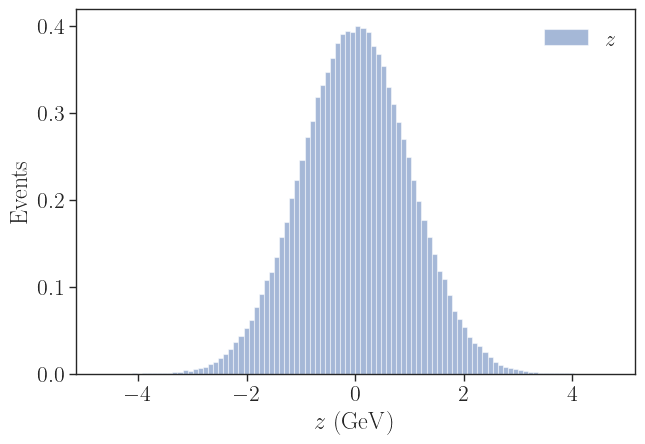

In [8]:
# Latent distribution
n_samples = 100000
z_gen = torch.randn((n_samples, n_dim))

print(z_gen.shape)

# Visualize the latent distribution
fig, axs = plt.subplots(figsize=(7,5))

axs.hist(z_gen.detach().numpy().flatten(), alpha=0.5, density=True, bins=100, label=r'$z$')

axs.set_xlabel('$z$ $(\mathrm{GeV})$')
axs.set_ylabel( r'$\mathrm{Events}$' )
axs.legend(loc='best', frameon=False)

fig.tight_layout()

In [9]:
# Generate m2 samples from latent distribution
mp_thetap_gen, _ = inn(z_gen, rev=True)
mp_thetap_gen = mp_thetap_gen.detach().numpy()[:]

print(mp_thetap_gen.shape)
print(mp_thetap_gen[0])

(100000, 2)
[0.14043613 0.73990333]


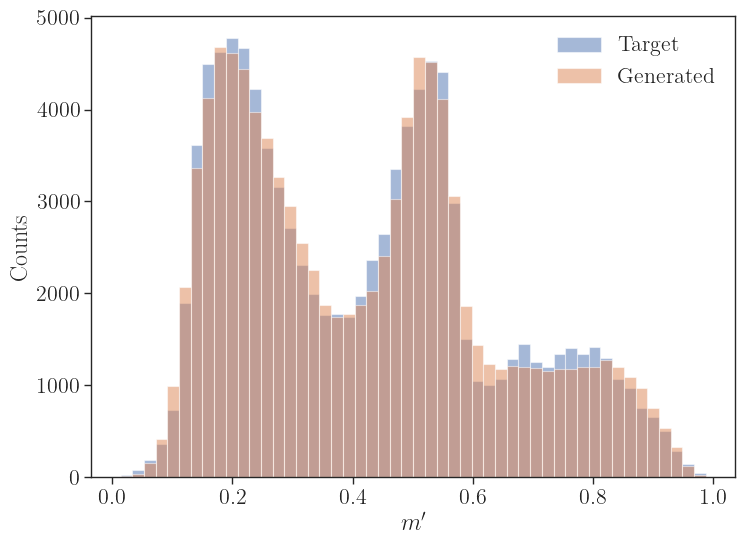

In [10]:
# Visualize 
fig, ax = plt.subplots( figsize=(8,6) )

counts, bins, _ = ax.hist(mp_thetap[:n_samples,0], 50, alpha = 0.5, label = r'$\mathrm{Target}$')
ax.hist(mp_thetap_gen[:,0], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$m'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()
fig.savefig(r'figs/D-amplitude_SDP_mp_INN_target_vs_gen_v2.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
fig.savefig(r'figs/D-amplitude_SDP_mp_INN_target_vs_gen_v2.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

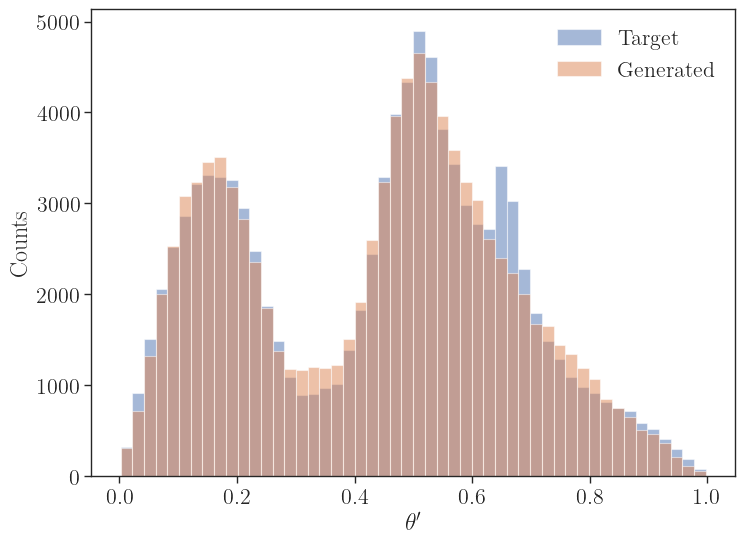

In [11]:
# Visualize 
fig, ax = plt.subplots( figsize=(8,6) )

counts, bins, _ = ax.hist(mp_thetap[:n_samples,1], 50, alpha = 0.5, label = r'$\mathrm{Target}$')
ax.hist(mp_thetap_gen[:,1], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$\theta'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()
fig.savefig(r'figs/D-amplitude_SDP_thetap_INN_target_vs_gen_v2.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
fig.savefig(r'figs/D-amplitude_SDP_thetap_INN_target_vs_gen_v2.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

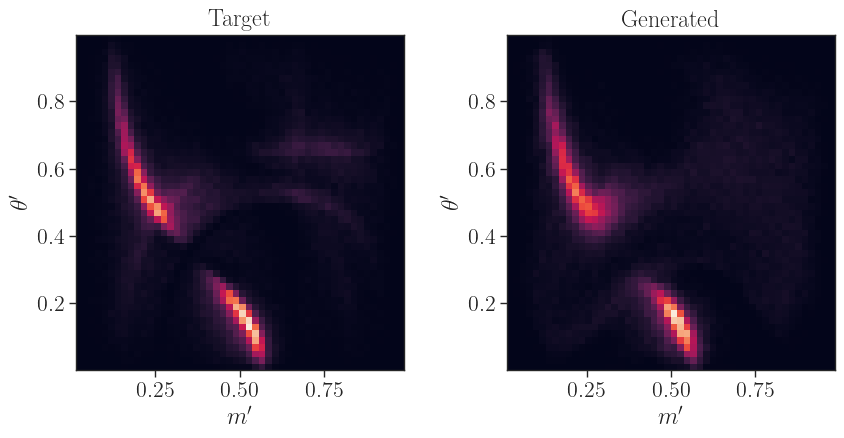

In [24]:
# Visualize 2D Dalitz plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5) )

h, xedges, yedges, _ = ax1.hist2d(mp_thetap[:n_samples,0], mp_thetap[:n_samples,1], 50)
ax2.hist2d(mp_thetap_gen[:,0], mp_thetap_gen[:,1], bins = [xedges, yedges])

ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Target}$')
ax1.set_aspect('equal')

ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Generated}$')
ax2.set_aspect('equal')

#ax.legend(loc='best', frameon=False)
fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
fig.savefig(r'figs/D-amplitude_SDP_INN_target.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
fig.savefig(r'figs/D-amplitude_SDP_INN_target.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')